## Import libraries
Import libraries for image plotting (plot and save aligned images and distortion maps) and elastix transformations (interface to elastix api).
numpy provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays efficiently.
Change working directory only run this once

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.chdir("\\".join(os.getcwd().split("\\")[:-1]))
#this should print path to automated elastix. If it doesnt the working directory is set incorrectly -> call IT support
print(os.getcwd())

from src.image_operations import ImageStuff
from src.facade import TransformElastix

C:\Users\biophys\PycharmProjects\automated_elastix


Set variables for the evaluation script. `root` is the path to your pre and post expansion images.
`EXPECTED_EXPASION` is the expected expansion factor from a first few on the images.
`post_expansion_file_name` is the file name of your post expansion image.
`pre_expansion_file_name` is the file name of your post expansion image (don't forget the extension i.e. ".tif") .

In [2]:
EXPECTED_EXPASION = 4
root = r"D:\Daten\Janna\2024PrePostAlignment\Trex"+"\\"
post_expansion_file_name = r"POST_TREx.tif"
pre_expansion_file_name = r"PRE_TREx.tif"

`save_dir` and `save_name` are automatically computed from your inputs. If you want to change them feel free to do so.
`ALIGNMENT_RESIZE` is important if images get too large. This computes the distortions on a downscale of the original images. (The plots use the original images)

In [3]:
save_dir = root + r"\results"+"\\"
save_name = pre_expansion_file_name.split(".")[0]
ALIGNMENT_RESIZE = 1

If your images have different px_sizes place them here

In [4]:
pre_expansion_px_size = 0.0526416
post_expansion_px_size = 0.0779907
px_size_factor = post_expansion_px_size/pre_expansion_px_size

Create save directory if it doesnt exist. Initialize importet libraries. Nothing to do here

In [5]:
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
image_op = ImageStuff()
transform = TransformElastix()

Resize pre Expansion image on `EXPECTED_EXPASION` factor. Substract base lvl. Apply `ALIGNMENT_RESIZE` if images are large

In [6]:
fixed = image_op.resize_image(root+pre_expansion_file_name, EXPECTED_EXPASION/ALIGNMENT_RESIZE)
fixed2 = image_op.resize_image(root+pre_expansion_file_name, EXPECTED_EXPASION)
fixed -= fixed.min()

moving = image_op.resize_image(root+post_expansion_file_name, 1/(ALIGNMENT_RESIZE))
moving -= moving.min()
moving2 = image_op.resize_image(root+post_expansion_file_name, 1/(1))

## Plot stuff and have a look at it.
These should look similar in pixelsize and orientation. If they don't use fiji for an initial crop and rotation.

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]

fig,axs = plt.subplots(1,2)
axs[0].imshow(moving)
axs[1].imshow(fixed)
plt.show()

If stuff does not workout here are some things you might try:
`clip` post expansion images on a lower value. i.e. set all values $\in [255, \infty]$ to 255. This compensates diluted signal to some lvl
`gaussian_filter` apply a gaussian filter to the moving image to get it close to the fixed image. Artificially worse resolution.

In [8]:
# moving = np.clip(moving, 0, moving.max()/5)
# moving =gaussian_filter(moving, sigma=2)

Set fixed and moving image

In [9]:
transform.fixed_image = fixed.astype(np.float32)
transform.moving_image = moving.astype(np.float32)

Compute similarity transform and read tranform parameters. Get `similarity_image` because we need it for the spline transformation

In [10]:
transform.similarity_transform()
TP = transform.STP
similarity_image = transform.result_image

Apply transform on unchanged moving image. This is only nescesarry if you applied `clip`,`gaussian` or `ALIGNMENT_RESIZE`

In [11]:
transform.moving_image = moving
transform.apply_similarity_transform(resize=ALIGNMENT_RESIZE, fixed=fixed2)
similarity_image2 = transform.t_result_image

### Show overlay

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


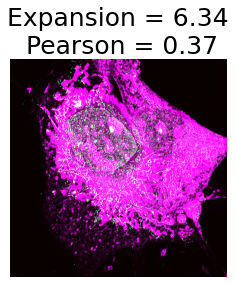

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


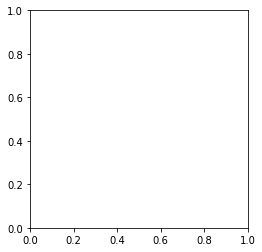

In [12]:
#show shows expansion factor in title
image_op.show_overlay(fixed2, similarity_image2, scale=EXPECTED_EXPASION*px_size_factor, TP=TP)
#save shows pearson correlation in title
image_op.show_overlay(fixed2, similarity_image2, save_path=save_dir+save_name+"similarity")

## Compute B-spline alignment
Set moving image to similarity image as initial transform

In [13]:
transform.moving_image = similarity_image
transform.b_spline_tranform()
spline_image = transform.result_image

SystemError: <built-in function ElastixImageFilter_Execute> returned a result with an exception set

### Show overlay
B-spline does not support resizing yet

In [ ]:
#show
image_op.show_overlay(fixed, spline_image)
#save
image_op.show_overlay(fixed, spline_image, save_path=save_dir+save_name+"spline")

Set distance of arrows for the distortion map and show the distortion map

In [ ]:
transform.SPACING = 60
#show
image_op.show_overlay(fixed2, similarity_image2,
                      scale=EXPECTED_EXPASION*px_size_factor, vec_map=transform.get_distortion_map(), TP=TP, save_path=save_dir+save_name+"distortion")
#save
image_op.show_overlay(fixed2, similarity_image2,
                      scale=EXPECTED_EXPASION*px_size_factor, vec_map=transform.get_distortion_map(), TP=TP)